In [ ]:
from google.colab import drive # 구글드라이브에서 파일 끌어올 경우'
import pandas as pd
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/20190120_Time_8_Altitude_22_Eastward_wind.csv")
df

Mounted at /content/drive


,Longitude (deg),Latitude (deg),Eastward wind (m/s)
0,89,231,15.634
1,89,232,18.181
2,89,233,20.451
3,89,234,22.005
4,89,235,23.681
...,...,...,...
4942,185,277,46.580
4943,185,278,47.345
4944,185,279,48.517
4945,185,280,50.392


# 1. Data Exploration

## import libraries

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import math

## Loading the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/ML_SNU/
import io
df = pd.read_csv('Data.csv')
df
df.columns = ['longitude', 'latitude', 'wind']


## Cecking outlier using Z-score

In [ ]:
# Z-스코어를 이용한 이상치 탐지 및 제거
z_scores = np.abs(stats.zscore(df))
threshold = 3  # Z-스코어 임계값 설정
df_no_outliers = df[(z_scores < threshold).all(axis=1)]


## Checking correlation between variable

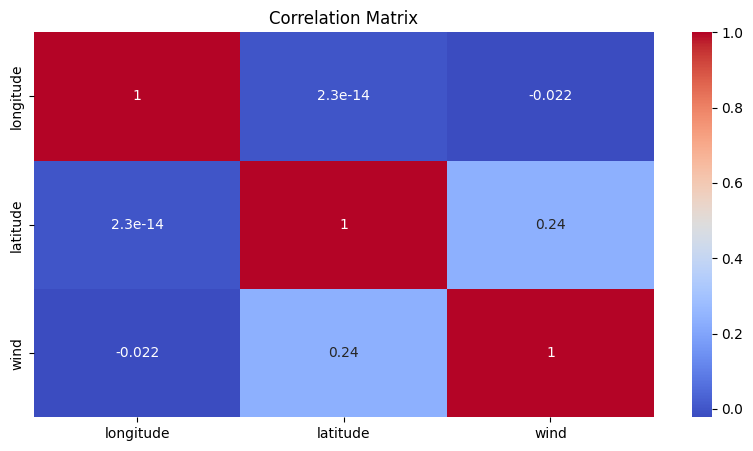

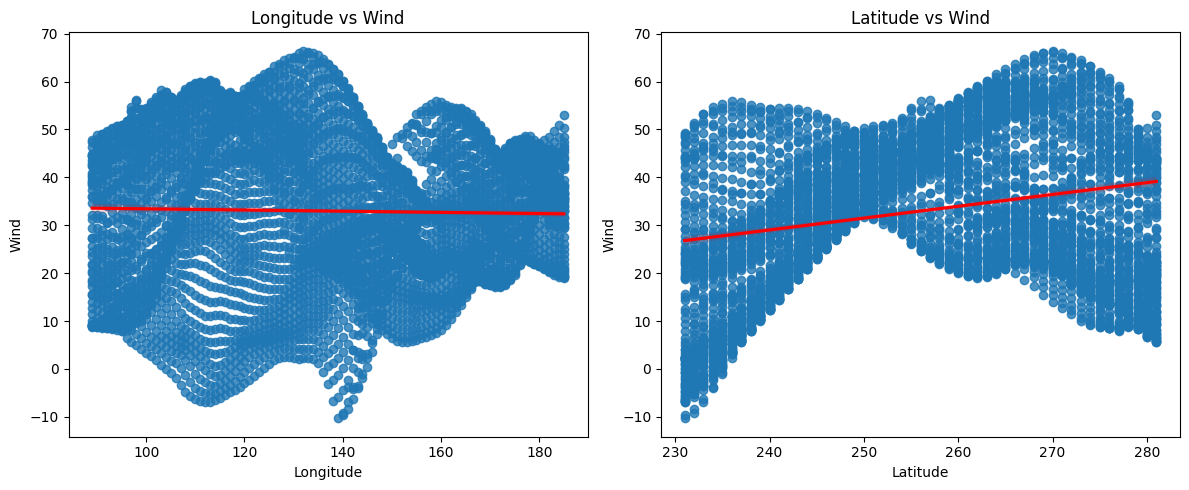

In [ ]:
# 변수 간의 상관관계 확인
plt.figure(figsize=(10, 5))
sns.heatmap(df_no_outliers.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# X1, X2 각각과 Y의 상관관계 플롯
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.regplot(x=df_no_outliers['longitude'], y=df_no_outliers['wind'], line_kws={"color": "red"})
plt.xlabel('Longitude')
plt.ylabel('Wind')
plt.title('Longitude vs Wind')

plt.subplot(1, 2, 2)
sns.regplot(x=df_no_outliers['latitude'], y=df_no_outliers['wind'], line_kws={"color": "red"})
plt.xlabel('Latitude')
plt.ylabel('Wind')
plt.title('Latitude vs Wind')

plt.tight_layout()
plt.show()



## Scaling and Splitting data

In [ ]:
# Prepare data
X = df_no_outliers[['longitude', 'latitude']]
y = df_no_outliers['wind']

# Data scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y = y.values.reshape(-1, 1)  # reshape for PyTorch compatibility

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Create dataset and dataloader
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))  # 80% train, 20% test
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 2. Simple Regression model


## Spllitting data

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle= True)


## Model fitting

In [ ]:
model = LinearRegression()
model.fit(x_train, y_train)

coef = model.coef_
intercept = model.intercept_
print(intercept, coef)

[33.09428353] [[-0.37778567  3.62083257]]


Linear Regression Equation : ***Eastward wind*** = 33.09428353 -0.37778567 X ***Longitude*** + 3.62083257 X ***Latitude***

## Evaluating the model performance


0.060032695246571344


Text(0.5, 1.0, 'The actual by predicted plot')

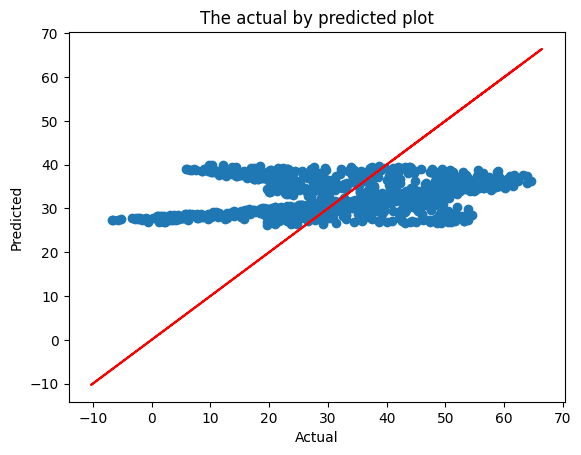

In [ ]:
y_pred = model.predict(x_test)

#R^2 square
SST = np.sum((y_test- np.mean(y_test))**2)
SSR = np.sum((y_pred - np.mean(y_test))**2)
R2 = SSR/SST
print(R2)

# The actual by predicted plot
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.plot(y_train, y_train, color = 'r')
plt.title('The actual by predicted plot')



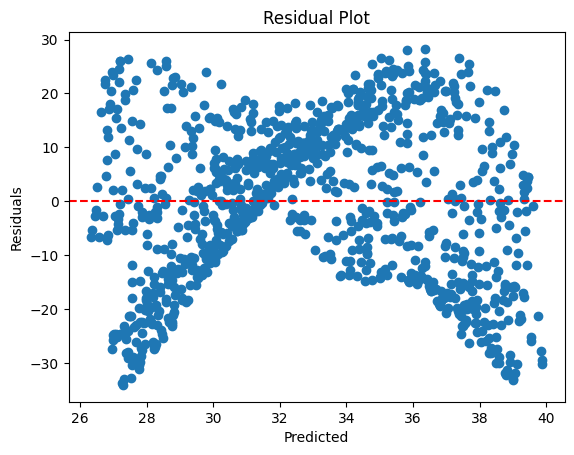

In [ ]:
# The residual by predicted plot
residual = y_test - y_pred
plt.scatter(y_pred, residual)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='--')

In [ ]:
# the model representation error value
rmse = np.sqrt(np.sum((y_test - y_pred)**2) / len(y_test))
print(rmse)

14.890212548192755


# 3.  MLP based Regression model

In [ ]:
# Define neural network model
class SimpleNN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim):
        super(SimpleNN, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.layer3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.layer3(x)
        return x

# L1 regularization loss function
def l1_loss_fn(model, loss_fn, lambda_l1):
    def loss(y_pred, y_true):
        mse_loss = loss_fn(y_pred, y_true)
        l1_penalty = sum(p.abs().sum() for p in model.parameters())
        return mse_loss + lambda_l1 * l1_penalty
    return loss

# L2 regularization loss function
def l2_loss_fn(model, loss_fn, lambda_l2):
    def loss(y_pred, y_true):
        mse_loss = loss_fn(y_pred, y_true)
        l2_penalty = sum(p.pow(2).sum() for p in model.parameters())
        return mse_loss + lambda_l2 * l2_penalty
    return loss

# ElasticNet regularization loss function
def elasticnet_loss_fn(model, loss_fn, lambda_l1, lambda_l2):
    def loss(y_pred, y_true):
        mse_loss = loss_fn(y_pred, y_true)
        l1_penalty = sum(p.abs().sum() for p in model.parameters())
        l2_penalty = sum(p.pow(2).sum() for p in model.parameters())
        return mse_loss + lambda_l1 * l1_penalty + lambda_l2 * l2_penalty
    return loss

# Model training function
def train_model(model, train_loader, loss_fn, optimizer, epochs=50):
    model.train()
    for epoch in range(epochs):
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            optimizer.step()

# Model evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            y_pred_batch = model(X_batch)
            y_true.extend(y_batch.numpy())
            y_pred.extend(y_pred_batch.numpy())
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, r2, y_true, y_pred

results = []
# Model, loss function, optimizer instantiation, training and evaluation
results = []
def run_experiment(loss_fn, hidden_dim, lambda_l1=0.0, lambda_l2=0.0):
    global results
    model = SimpleNN(input_dim=2, output_dim=1, hidden_dim=hidden_dim)
    if loss_fn == 'l1':
        loss_function = l1_loss_fn(model, nn.MSELoss(), lambda_l1)
    elif loss_fn == 'l2':
        loss_function = l2_loss_fn(model, nn.MSELoss(), lambda_l2)
    elif loss_fn == 'elasticnet':
        loss_function = elasticnet_loss_fn(model, nn.MSELoss(), lambda_l1, lambda_l2)
    else:
        loss_function = nn.MSELoss()

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_model(model, train_loader, loss_function, optimizer, epochs=50)
    mse, mae, r2, y_true, y_pred = evaluate_model(model, test_loader)

    results.append({
        'hidden_dim': hidden_dim,
        'regularization': loss_fn,
        'mse': mse
    })

    print(f"{loss_fn} regularization with hidden_dim={hidden_dim}: MSE={mse}, MAE={mae}, R2={r2}")



# Run experiments to test hyper parameters(hidden_dim and regularization)
hidden_dims = [50, 100, 300]
for hidden_dim in hidden_dims:
    print(f"Running experiments with hidden_dim={hidden_dim}")
    print("Training with L1 regularization")
    run_experiment('l1', hidden_dim, lambda_l1=0.01)
    print("Training with L2 regularization")
    run_experiment('l2', hidden_dim, lambda_l2=0.01)
    print("Training with ElasticNet regularization")
    run_experiment('elasticnet', hidden_dim, lambda_l1=0.01, lambda_l2=0.01)


Running experiments with hidden_dim=50
Training with L1 regularization
l1 regularization with hidden_dim=50: MSE=28.27447509765625, MAE=3.6116280555725098, R2=0.8834337622526992
Training with L2 regularization
l2 regularization with hidden_dim=50: MSE=19.912639617919922, MAE=3.0469648838043213, R2=0.9179068252100734
Training with ElasticNet regularization
elasticnet regularization with hidden_dim=50: MSE=20.927833557128906, MAE=3.2806496620178223, R2=0.9137215130480181
Running experiments with hidden_dim=100
Training with L1 regularization
l1 regularization with hidden_dim=100: MSE=25.071985244750977, MAE=3.290876865386963, R2=0.896636562528042
Training with L2 regularization
l2 regularization with hidden_dim=100: MSE=12.59086799621582, MAE=2.4817285537719727, R2=0.9480920502873187
Training with ElasticNet regularization
elasticnet regularization with hidden_dim=100: MSE=12.856831550598145, MAE=2.5203909873962402, R2=0.9469955708820728
Running experiments with hidden_dim=300
Training w

In [ ]:
# experiment result
results_df = pd.DataFrame(results)
print(results_df)

   hidden_dim regularization        mse
0          50             l1  28.274475
1          50             l2  19.912640
2          50     elasticnet  20.927834
3         100             l1  25.071985
4         100             l2  12.590868
5         100     elasticnet  12.856832
6         300             l1   9.061666
7         300             l2   9.695807
8         300     elasticnet  11.355348


In [ ]:
# training the model with best hyper parameter
model = SimpleNN(input_dim=2, output_dim=1, hidden_dim=300)
loss_function = l1_loss_fn(model, nn.MSELoss(), lambda_l1= 0.01)
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_model(model, train_loader, loss_function, optimizer, epochs=50)
mse, mae, r2, y_true, y_pred = evaluate_model(model, test_loader)


# 4. MLP Based Model Evaluation

## R-Squared of test data

In [ ]:
print("R-Square value  : ",r2)

R-Square value  :  0.9559352654005211


## Actual and predicted plot

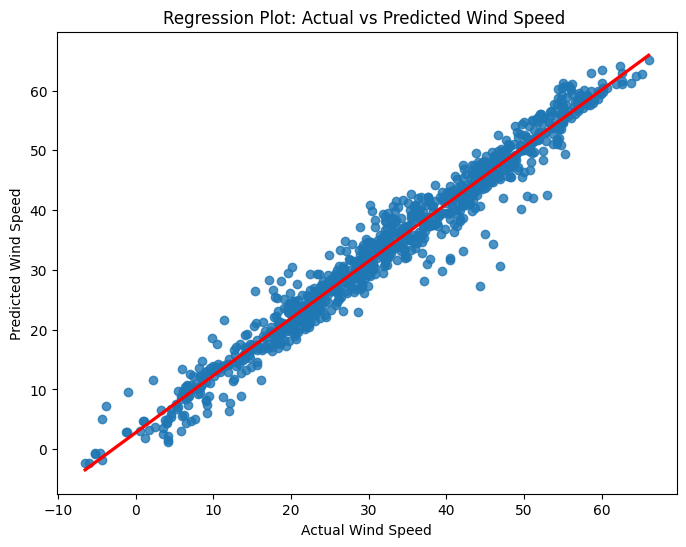

In [ ]:

    plt.figure(figsize=(8, 6))
    sns.regplot(x=y_true, y=y_pred, line_kws={"color": "red"})
    plt.xlabel('Actual Wind Speed')
    plt.ylabel('Predicted Wind Speed')
    plt.title(f'Regression Plot: Actual vs Predicted Wind Speed ')
    plt.show()

## Residual plot

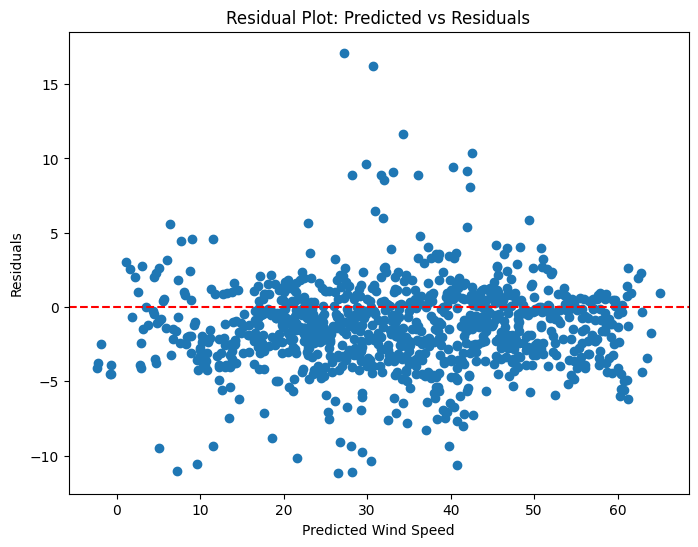

In [ ]:
residuals = y_true - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(x=y_pred, y=residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Wind Speed')
plt.ylabel('Residuals')
plt.title(f'Residual Plot: Predicted vs Residuals')
plt.show()

## Model Representation Error

In [ ]:
# calculating model fit error
mse, mae, r2, y_true, y_pred = evaluate_model(model, train_loader)
mfe = math.sqrt(mse)

mse, mae, r2, y_true, y_pred = evaluate_model(model, test_loader)
mre = math.sqrt(mse)

In [ ]:
print(mre)
print(mfe)

3.1867674939579254
3.1397934757031964
